In [39]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers.experimental import RandomFourierFeatures
from imgaug import augmenters as iaa

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.layers import Dropout, Dense, Input, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.layers import Layer, Conv2D, Flatten, BatchNormalization, Concatenate, Multiply, Average
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical, plot_model

In [40]:
# Auxiliary function for data distribution visualization
def data_visualization(classes, data):
    """
    Vizualize the distribution of the dataset.
  
    This function presents the number of samples each category has
    through a bar plot.

    Args:
        classes (list): List of the emotion-categories
        data (list): List of the number of images per category 
 
    Returns:
        No value
    """

    fig, ax = plt.subplots(figsize=(9, 5))
    ax.bar(classes, data)
    ax.set(title="Dataset's distribution for each class")
    ax.set(xlabel="Classes", ylabel="#Images");
    ax.grid()


def load_data(data_path, image_size):
    """
    Load the dataset to the memory.
  
    This function takes a data path and loads all images (along with their
    corresponding labels) as numpy arrays per category to the memory.
    Subsequently, the labels are one-hot encoded. Before the images, labels
    are returned, the distribution of the dataset is presented.

    Args:
        data_path (str): The path of the dataset's whereabouts
   
    Returns:
        data (numpy.ndarray): The images of the dataset
        labels (numpy.ndarray): The labels of each image
    """

    subfolders_ck = os.listdir(data_path)

    print("[INFO] Dataset Loading...\n")

    img_data_list=[]
    labels_list = []
    num_images_per_class = []

    for category in subfolders_ck:
        img_list=os.listdir(data_path +'/'+ category)
        
        print('Loading :', len(img_list), 'images of category: ', category)
        for img in img_list:
            # Load an image from this path
            image = cv2.imread(data_path + '/'+ category + '/'+ img )
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            array = cv2.resize(image, (image_size[0],image_size[1]), fx=1, fy=1,interpolation = cv2.INTER_CUBIC)        
            img_data_list.append(array)          
            labels_list.append(category)
        num_images_per_class.append(len(img_list))

    le = LabelEncoder()
    labels = le.fit_transform(labels_list)
    labels = to_categorical(labels)
    data = np.array(img_data_list)
    
    data_visualization(subfolders_ck, num_images_per_class)

    # Dataset Summary
    print("\nTotal number of uploaded data: ", data.shape[0],
          ", with data shape", (data.shape[1],data.shape[2],data.shape[3]), "\n")

    return data, labels

[INFO] Dataset Loading...

Loading : 93 images of category:  normal
Loading : 135 images of category:  cataract

Total number of uploaded data:  228 , with data shape (156, 156, 3) 

[INFO] Dataset Loading...

Loading : 16 images of category:  normal
Loading : 17 images of category:  cataract

Total number of uploaded data:  33 , with data shape (156, 156, 3) 

X_train has shape: (228, 156, 156, 3)
y_train has shape: (228, 2)

X_test has shape: (33, 156, 156, 3)
y_test has shape: (33, 2)

X_train + X_test = 261 samples in total


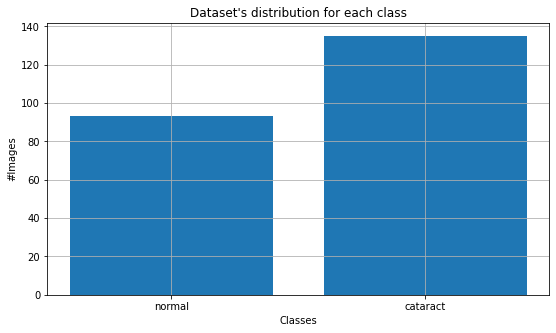

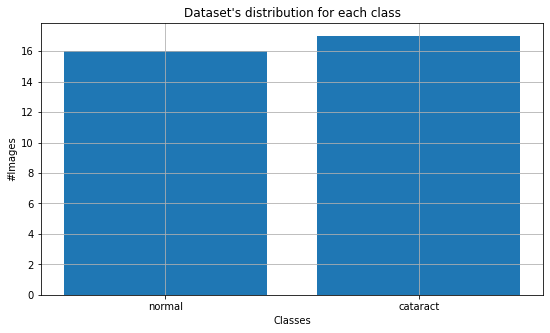

In [41]:
image_size = (156,156,3)
train_data_path = "/kaggle/input/cataracteyeskaggle/cataract-eyes-kaggle/train"
X_train, y_train = load_data(train_data_path,image_size)

test_data_path = "/kaggle/input/cataracteyeskaggle/cataract-eyes-kaggle/test"
X_test, y_test = load_data(test_data_path,image_size)

print(f"X_train has shape: {X_train.shape}")
print(f"y_train has shape: {y_train.shape}\n")

print(f"X_test has shape: {X_test.shape}")
print(f"y_test has shape: {y_test.shape}\n")

print(f"X_train + X_test = {X_train.shape[0] + X_test.shape[0]} samples in total")

/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:337: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


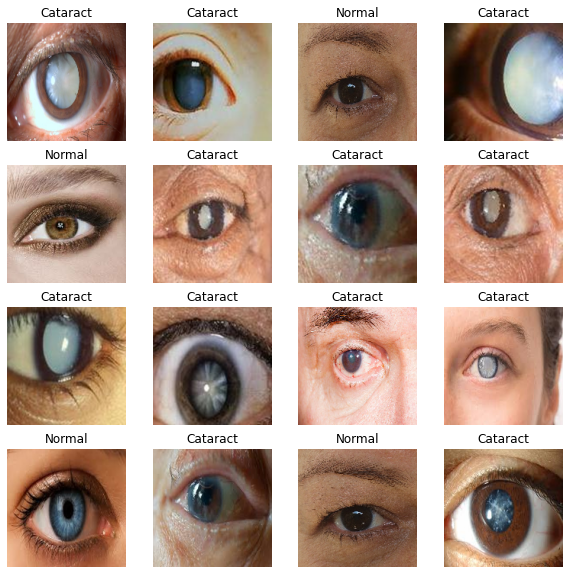

In [42]:
# Map the disease categories
mapping = { 0:'Cataract', 1:'Normal'}

# Initialize the training data augmentation object
trainAug = ImageDataGenerator(zca_whitening=True,
    #rotation_range=15,
    #zoom_range=0.15,
    #width_shift_range=0.2,
    #brightness_range=(.6, 1.2),
    #shear_range=.15,
    #height_shift_range=0.2,
    #horizontal_flip=True,
    fill_mode="nearest")

# Randomly vizualize some augmented samples
plt.figure(figsize=(10,10))
for i, (image, label) in enumerate(trainAug.flow(X_train, y_train, batch_size=1)):
    if i == 16:
        break

    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(np.squeeze(image)/255.)
    plt.title(mapping[np.argmax(label)])
    plt.axis("off")

In [43]:
from keras.layers import Conv1D, Conv2D, Conv3D
from keras.layers import Reshape
from keras.layers import Activation
from keras.layers import Softmax
from keras.layers import Permute
from keras.layers import add, dot

from keras import backend as K


def GlobalContextBlock(ip, reduction_ratio=16, transform_activation='linear'):
    """
    Adds a Global Context attention block for self attention to the input tensor.
    Input tensor can be or rank 3 (temporal), 4 (spatial) or 5 (spatio-temporal).

    # Arguments:
        ip: input tensor
        intermediate_dim: The dimension of the intermediate representation. Can be
            `None` or a positive integer greater than 0. If `None`, computes the
            intermediate dimension as half of the input channel dimension.
        reduction_ratio: Reduces the input filters by this factor for the
            bottleneck block of the transform submodule. Node: the reduction
            ratio must be set such that it divides the input number of channels,
        transform_activation: activation function to apply to the output
            of the transform block. Can be any string activation function availahle
            to Keras.

    # Returns:
        a tensor of same shape as input
    """
    channel_dim = 1 if K.image_data_format() == 'channels_first' else -1
    ip_shape = K.int_shape(ip)

    # check rank and calculate the input shape
    if len(ip_shape) == 3:  # temporal / time series data
        rank = 3
        batchsize, dim1, channels = ip_shape

    elif len(ip_shape) == 4:  # spatial / image data
        rank = 4

        if channel_dim == 1:
            batchsize, channels, dim1, dim2 = ip_shape
        else:
            batchsize, dim1, dim2, channels = ip_shape

    elif len(ip_shape) == 5:  # spatio-temporal / Video or Voxel data
        rank = 5

        if channel_dim == 1:
            batchsize, channels, dim1, dim2, dim3 = ip_shape
        else:
            batchsize, dim1, dim2, dim3, channels = ip_shape

    else:
        raise ValueError('Input dimension has to be either 3 (temporal), 4 (spatial) or 5 (spatio-temporal)')

    if rank > 3:
        flat_spatial_dim = -1 if K.image_data_format() == 'channels_first' else 1
    else:
        flat_spatial_dim = 1

    """ Context Modelling Block """
    # [B, ***, C] or [B, C, ***]
    input_flat = _spatial_flattenND(ip, rank)
    # [B, ..., C] or [B, C, ...]
    context = _convND(ip, rank, channels=1, kernel=1)
    # [B, ..., 1] or [B, 1, ...]
    context = _spatial_flattenND(context, rank)
    # [B, ***, 1] or [B, 1, ***]
    context = Softmax(axis=flat_spatial_dim)(context)

    # Compute context block outputs
    context = dot([input_flat, context], axes=flat_spatial_dim)
    # [B, C, 1]
    context = _spatial_expandND(context, rank)
    # [B, C, 1...] or [B, 1..., C]

    """ Transform block """
    # Transform bottleneck
    # [B, C // R, 1...] or [B, 1..., C // R]
    transform = _convND(context, rank, channels // reduction_ratio, kernel=1)
    # Group normalization acts as Layer Normalization when groups = 1
    #transform = GroupNormalization(groups=1, axis=channel_dim)(transform)
    transform = Activation('relu')(transform)

    # Transform output block
    # [B, C, 1...] or [B, 1..., C]
    transform = _convND(transform, rank, channels, kernel=1)
    transform = Activation(transform_activation)(transform)

    # apply context transform
    out = add([ip, transform])

    return out


def _convND(ip, rank, channels, kernel=1):
    assert rank in [3, 4, 5], "Rank of input must be 3, 4 or 5"

    if rank == 3:
        x = Conv1D(channels, kernel, padding='same', use_bias=False, kernel_initializer='he_normal')(ip)
    elif rank == 4:
        x = Conv2D(channels, (kernel, kernel), padding='same', use_bias=False, kernel_initializer='he_normal')(ip)
    else:
        x = Conv3D(channels, (kernel, kernel, kernel), padding='same', use_bias=False, kernel_initializer='he_normal')(ip)

    return x


def _spatial_flattenND(ip, rank):
    assert rank in [3, 4, 5], "Rank of input must be 3, 4 or 5"

    ip_shape = K.int_shape(ip)
    channel_dim = 1 if K.image_data_format() == 'channels_first' else -1

    if rank == 3:
        x = ip  # identity op for rank 3

    elif rank == 4:
        if channel_dim == 1:
            # [C, D1, D2] -> [C, D1 * D2]
            shape = [ip_shape[1], ip_shape[2] * ip_shape[3]]
        else:
            # [D1, D2, C] -> [D1 * D2, C]
            shape = [ip_shape[1] * ip_shape[2], ip_shape[3]]

        x = Reshape(shape)(ip)

    else:
        if channel_dim == 1:
            # [C, D1, D2, D3] -> [C, D1 * D2 * D3]
            shape = [ip_shape[1], ip_shape[2] * ip_shape[3] * ip_shape[4]]
        else:
            # [D1, D2, D3, C] -> [D1 * D2 * D3, C]
            shape = [ip_shape[1] * ip_shape[2] * ip_shape[3], ip_shape[4]]

        x = Reshape(shape)(ip)

    return x


def _spatial_expandND(ip, rank):
    assert rank in [3, 4, 5], "Rank of input must be 3, 4 or 5"

    channel_dim = 1 if K.image_data_format() == 'channels_first' else -1

    if rank == 3:
        x = Permute((2, 1))(ip)  # identity op for rank 3

    elif rank == 4:
        if channel_dim == 1:
            # [C, D1, D2] -> [C, D1 * D2]
            shape = [-1, 1, 1]
        else:
            # [D1, D2, C] -> [D1 * D2, C]
            shape = [1, 1, -1]

        x = Reshape(shape)(ip)

    else:
        if channel_dim == 1:
            # [C, D1, D2, D3] -> [C, D1 * D2 * D3]
            shape = [-1, 1, 1, 1]
        else:
            # [D1, D2, D3, C] -> [D1 * D2 * D3, C]
            shape = [1, 1, 1, -1]

        x = Reshape(shape)(ip)

    return x

In [44]:
def SpatialAttention(fmaps):
    SA_A = tf.reduce_mean(fmaps,[0,3],keepdims=True) # Depth-wise Average Pooling
    Conv_A = Conv2D(1,3,activation='sigmoid',padding="same")(SA_A) # Apply Softmax based gated attention on Average-Spatial Map
    sa_fmaps = Multiply()([fmaps,Conv_A]) # multiply all feature maps with average spatial attention map
    return sa_fmaps

def ChannelAttention(fmaps):
    GAP = GlobalAveragePooling2D()(fmaps)
    FC1 = Dense(fmaps.shape[3]//8, activation='tanh')(GAP)
    FC2 = Dense(fmaps.shape[3], activation='sigmoid')(FC1)
    ca_fmaps = Multiply()([fmaps,FC2])
    return ca_fmaps

def build_model():
    
    inputs = Input(shape=image_size)
    base_model = EfficientNetB4(include_top=False, weights='imagenet',drop_connect_rate=0.5, input_tensor=inputs)
    for layer in base_model.layers:
        layer.trainable=False
    fmaps = base_model.output
    
    #Add Spatial Attention Layer
    sa_fmaps = SpatialAttention(fmaps)
    
    SA_GAP = GlobalAveragePooling2D()(sa_fmaps) # Squeeze average attention maps
    
    #Add Channel Attention Layer
    ca_fmaps = ChannelAttention(fmaps)
    
    CA_GAP = GlobalAveragePooling2D()(sa_fmaps) # Squeeze average attention maps
    
    GAP = GlobalAveragePooling2D()(fmaps) # Squeeze average maps
    
    gc_fmaps = GlobalContextBlock(fmaps)
    
    GC_GAP = GlobalAveragePooling2D()(gc_fmaps) # Squeeze average maps
    
    fused_fmaps = Concatenate()([GAP,SA_GAP,CA_GAP, GC_GAP])
    
    outputs = Dense(2, activation='softmax')(fused_fmaps)
    model = Model(inputs, outputs)

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])#Adam(learning_rate=1e-3)

    return model

# Create an object of the model
model = build_model()

In [45]:
from contextlib import redirect_stdout

with open('modelsummary.txt', 'w') as f:
    with redirect_stdout(f):
        model.summary()

#print(model.summary())
#plot_model(model, show_shapes=True, to_file='model.png')

In [64]:
EPOCHS = 100
batch_size = 64
filepath = "/kaggle/working/external-eyes_cataract_classsifier.h5"

# Define the necessary callbacks
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
earlystopping = EarlyStopping(monitor='val_accuracy', patience=25, verbose=1, mode='auto', restore_best_weights=True)
rlrop = ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=3, factor=0.3, min_lr=1e-6, verbose=1)

callbacks = [checkpoint, rlrop, earlystopping] 

print(f"[INFO] training network for {EPOCHS} epochs...\n")
hist = model.fit(trainAug.flow(X_train, y_train, batch_size=batch_size),
                 steps_per_epoch=len(X_train) // batch_size,
                 validation_data=(X_test, y_test),
                 epochs=EPOCHS, callbacks=callbacks)

[INFO] training network for 100 epochs...

Epoch 1/100
3/3 [==============================] - 6s 189ms/step - loss: 0.2755 - accuracy: 0.8963 - val_loss: 0.2989 - val_accuracy: 0.8788

Epoch 00001: val_accuracy improved from -inf to 0.87879, saving model to /kaggle/working/external-eyes_cataract_classsifier.h5
Epoch 2/100
3/3 [==============================] - 1s 191ms/step - loss: 0.2168 - accuracy: 0.9323 - val_loss: 0.2084 - val_accuracy: 0.9091

Epoch 00002: val_accuracy improved from 0.87879 to 0.90909, saving model to /kaggle/working/external-eyes_cataract_classsifier.h5
Epoch 3/100
3/3 [==============================] - 1s 194ms/step - loss: 0.2049 - accuracy: 0.9167 - val_loss: 0.2486 - val_accuracy: 0.8485

Epoch 00003: val_accuracy did not improve from 0.90909
Epoch 4/100
3/3 [==============================] - 0s 191ms/step - loss: 0.2197 - accuracy: 0.9146 - val_loss: 0.2397 - val_accuracy: 0.9091

Epoch 00004: val_accuracy did not improve from 0.90909
Epoch 5/100
3/3 [=====

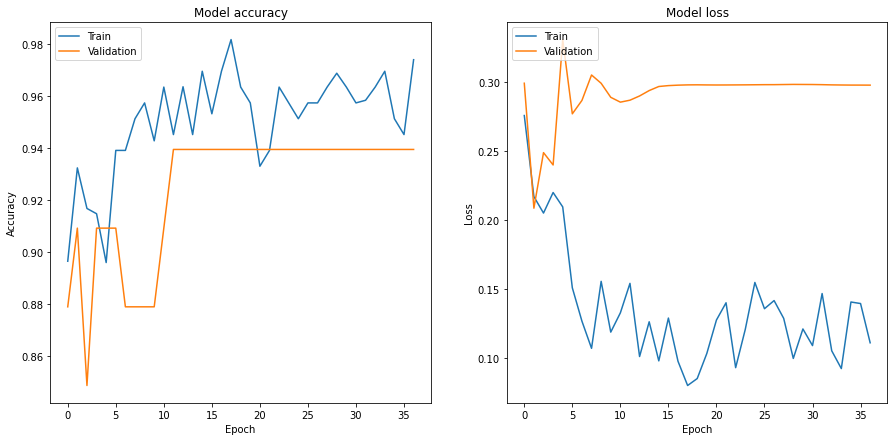

In [65]:
# Clear the values of previous plot
%matplotlib inline

fig = plt.figure(figsize=(15, 7))

# Plot training & validation accuracy values
fig.add_subplot(121)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('Training & Validation Accuracy Plot')

# Plot training & validation loss values
fig.add_subplot(122)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('Training & Validation Loss Plot')

In [66]:
model = load_model(filepath)

model.evaluate(X_test, y_test)

2/2 [==============================] - 3s 23ms/step - loss: 0.2866 - accuracy: 0.9394


[0.28660067915916443, 0.939393937587738]

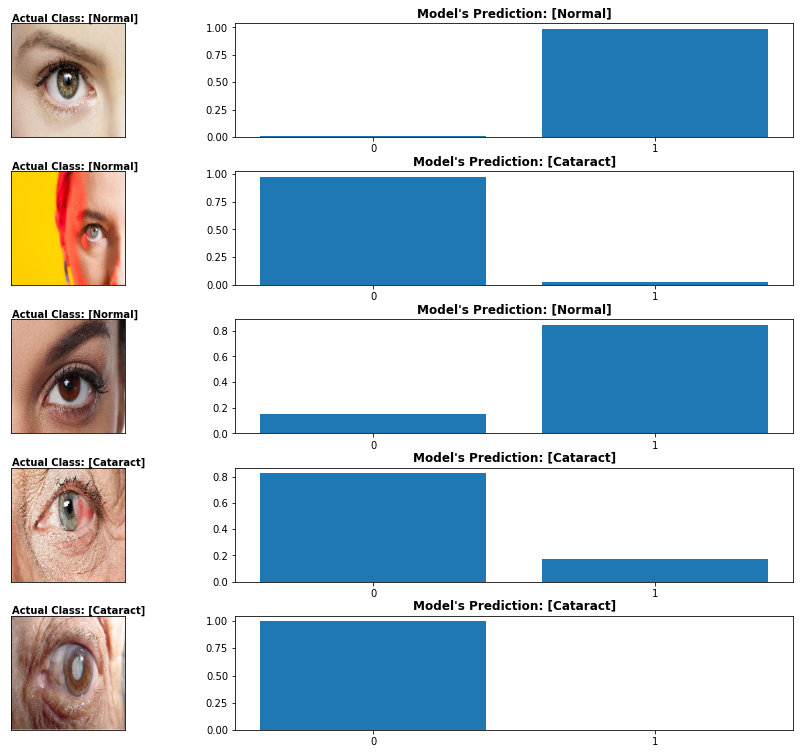

In [67]:
samples = np.random.choice(len(X_test), 5)

predictions = model.predict(X_test[samples], verbose=0)

fig, axes = plt.subplots(len(samples), 2, figsize=(18, 13))
fig.subplots_adjust(hspace=0.3, wspace=-0.2)

for i, (prediction, image, label) in enumerate(zip(predictions, X_test[samples], y_test[samples])):

    axes[i, 0].imshow(np.squeeze(image/255.))
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(1., -3, f'Actual Class: [{mapping[np.argmax(label)]}]', weight='bold')

    axes[i, 1].bar(np.arange(len(prediction)), prediction)
    axes[i, 1].set_xticks(np.arange(len(prediction)))
    axes[i, 1].set_title(f"Model's Prediction: [{mapping[np.argmax(prediction)]}]", weight='bold')

In [68]:
y_score = model.predict(X_test)
y_pred = np.argmax(y_score,axis=-1)
Y_test = np.argmax(y_test,axis=-1)

In [69]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,cohen_kappa_score,roc_auc_score,confusion_matrix

acc = accuracy_score(Y_test,y_pred)
mpre = precision_score(Y_test,y_pred,average='macro')
mrecall = recall_score(Y_test,y_pred,average='macro')
mf1 = f1_score(Y_test,y_pred,average='macro')
kappa = cohen_kappa_score(Y_test,y_pred,weights='quadratic')
auc = roc_auc_score(Y_test, y_pred, average='macro', multi_class='ovr')


print("Accuracy: ",round(acc*100,2))
print("Macro Precision: ",round(mpre*100,2))
print("Macro Recall: ",round(mrecall*100,2))
print("Macro F1-Score: ",round(mf1*100,2))
print("Quadratic Kappa Score: ",round(kappa*100,2))
print("ROC AUC Score: ",round(auc*100,2))

Accuracy:  93.94
Macro Precision:  94.74
Macro Recall:  93.75
Macro F1-Score:  93.89
Quadratic Kappa Score:  87.82
ROC AUC Score:  93.75


In [70]:
from sklearn.metrics import classification_report

print(classification_report(Y_test, y_pred, digits=4, target_names = ['Cataract','Normal']))

              precision    recall  f1-score   support

    Cataract     0.8947    1.0000    0.9444        17
      Normal     1.0000    0.8750    0.9333        16

    accuracy                         0.9394        33
   macro avg     0.9474    0.9375    0.9389        33
weighted avg     0.9458    0.9394    0.9391        33



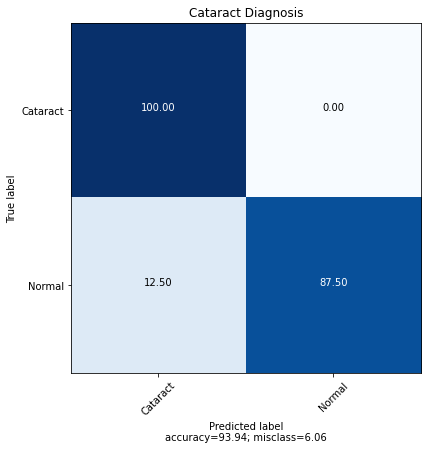

In [71]:
def plot_confusion_matrix(cm, target_names, title='Confusion Matrix', cmap=None, normalize=True):
    
    import itertools
    import numpy as np
    import matplotlib.pyplot as plt

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)


    #thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]*100),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.2f}; misclass={:0.2f}'.format(accuracy*100, misclass*100))
    plt.show()


# plot confusion matrix
cm = confusion_matrix(Y_test,y_pred)
targets = ['Cataract','Normal']
plot_confusion_matrix(cm, target_names = targets, title='Cataract Diagnosis', cmap='Blues', normalize=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


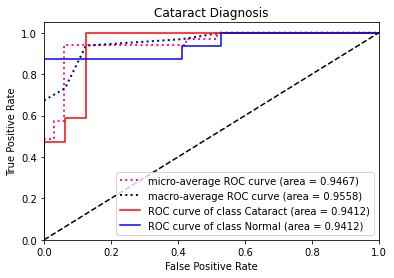

In [72]:
from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

num_classes=2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.4f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=2)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.4f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=2)

colors = cycle(['red','blue','green','darkorange', 'purple', 'cyan', 'violet', 'peru', 'black', 'gold'])
classes = ['Cataract','Normal']
lw = 1.5

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.4f})'
             ''.format(classes[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Cataract Diagnosis')
plt.legend(loc="lower right")
plt.show()